In [1]:
# Installing YOLOv10 API
!pip install -q git+https://github.com/THU-MIG/yolov10.git

In [3]:
# Necessary imports
import os
import yaml
import shutil
import requests
import pandas as pd
from tqdm import tqdm
from datetime import datetime
from ultralytics import YOLOv10
import cv2
import matplotlib.pyplot as plt
from PIL import Image
import matplotlib.patches as patches

In [3]:
# Downloading the yolov10 models for hyperparammeter tuning

HOME = os.getcwd()

if not os.path.exists(f"{HOME}/weights"):
    os.mkdir (f"{HOME}/weights")
for size in ["n", "m", "l"]:
    url = f"https://github.com/jameslahm/yolov10/releases/download/v1.0/yolov10{size}.pt"
    local_filename = os.path.join("weights/", url.split('/')[-1])
    with requests.get(url, stream=True) as r:
        with open(local_filename, 'wb') as f:
            shutil.copyfileobj(r.raw, f)

In [3]:
# Installing roboflow to download the dataset

!pip install roboflow

Looking in indexes: https://pypi.org/simple, https://pypi.ngc.nvidia.com


In [4]:
# Downloading the Dataset from roboflow

if not os.path.exists("datasets"):

    from roboflow import Roboflow
    # dataset from https://universe.roboflow.com/david-glu/cotskaggle

    ROBOFLOW_API_KEY = "rWU1eQHaSgCK3DzRY2TP"
    rf = Roboflow(api_key=ROBOFLOW_API_KEY)
    project = rf.workspace("great-barrier-reef").project("great-barrier-reef-o5scc")
    dataset = project.version(5).download("yolov8")

In [5]:
# Changing the directory containing the dataset so that it is consistent with the data.yaml

if not os.path.exists("datasets"):
    os.mkdir("datasets")
    shutil.move(f"{HOME}/Great-Barrier-Reef-5", f"{HOME}/datasets")

In [6]:
# replace class 'json' to 'starfish' in data.yaml

DATASET_PATH = f'{HOME}/datasets/Great-Barrier-Reef-5/'

with open(DATASET_PATH + 'data.yaml', 'r') as f:
    data = yaml.safe_load(f)

data['names'] = ['starfish']
data['train'] = DATASET_PATH + 'train/images'
data['val'] = DATASET_PATH + 'valid/images'
data['test'] = DATASET_PATH +'test/images'

with open(DATASET_PATH + 'data.yaml', 'w') as file:
    yaml.dump(data, file, indent=4)

In [59]:
def label_path_to_bbox(label_path: str, normalized=True) -> list:
    # This function translates the outputs from YOLO to bounding box format ready for plotting
    with open(label_path, 'r') as file:
        # Read the content of the file
        file_content = file.read()
        
    detections = file_content.split('\n')
#     print(detections)
    str_boxes = [str_box.split(' ') for str_box in detections]
#     print(str_boxes)
    
    bboxes = []
    
    if normalized == False:
        image_path = label_path.replace('.txt','.jpg').replace( "labels", "images")
        image_width, image_height = Image.open(image_path).size
    
    for str_box in str_boxes:
        str_box_no_class = str_box[1:]
        float_box = [float(value) for value in str_box_no_class]
        
        if normalized == False:
            x_center = float_box[0] * image_width
            y_center = float_box[1] * image_height
            width = float_box[2] * image_width
            height = float_box[3] * image_height
            float_box = [x_center, y_center, width, height]
           
        bboxes.append(float_box)
        
    return bboxes    

In [8]:
def plot_image_with_bboxes(image, bboxes, normalized=True):
    # This function plots an image with the bounding box which is the output from YOLO
    fig, ax = plt.subplots(1, figsize=(12, 9))
    # Display the image
    ax.imshow(image)
    # Get image dimensions
    image_width, image_height = image.size
    # Plot each bounding box
    for bbox in bboxes:
        if normalized == False:
            x_center = bbox[0]
            y_center = bbox[1]
            width = bbox[2]
            height = bbox[3]
        else:   
            x_center = bbox[0] * image_width
            y_center = bbox[1] * image_height
            width = bbox[2] * image_width
            height = bbox[3] * image_height
        
        # Calculate the top-left corner of the rectangle
        top_left_x = x_center - width / 2
        top_left_y = y_center - height / 2
        
        rect = patches.Rectangle((top_left_x, top_left_y), width, height, linewidth=1, edgecolor='r', facecolor='none')
        ax.add_patch(rect)
#         ax.plot(x_center, y_center, 'ro')  # 'ro' means red color and circle marker

    plt.axis('off')
    plt.show()

In [9]:
def display_image_path_with_label_path(image_path, label_path):
    # This function takes as input the paths to an image and its label file, and plots the image with the bounding boxes described in the label file
    with open(label_path, 'r') as file:
        # Read the content of the file
        file_content = file.read()

    bboxes = label_path_to_bbox(label_path)

    # Load the image
    image = Image.open(image_path)
    
    # display images with annotations
    plot_image_with_bboxes(image, bboxes)

image path: h:\python_projects\deep_learning_technion\project\Starfish-Object-detection/datasets/Great-Barrier-Reef-5/train/images\0-9361_jpg.rf.fa7d0cbb325a50449ac34ec3811c18cc.jpg


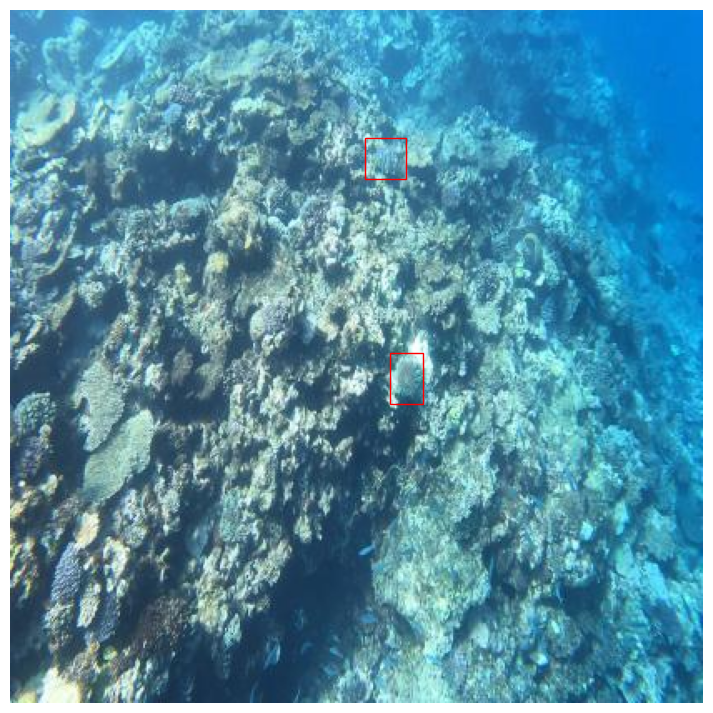

bbox: [[237.5, 220.49999999999997, 20.0, 30.5], [225.0, 88.5, 24.5, 24.5]]
normalized bbox: [[0.5709134615384616, 0.5300480769230769, 0.04807692307692308, 0.0733173076923077], [0.5408653846153846, 0.2127403846153846, 0.05889423076923077, 0.05889423076923077]]


In [10]:
# Here we present a random sample from the dataset, with its labels

import random

IMAGE_PATH = DATASET_PATH + 'train/images'

train_images = os.listdir(IMAGE_PATH)

random_image = random.choice(train_images)
# print(random_image)
image_path = os.path.join(IMAGE_PATH, random_image)
label_path = image_path.replace("images", "labels").replace(".jpg", ".txt")
print(f"image path: {image_path}")

display_image_path_with_label_path(image_path, label_path)

print(f"bbox: {label_path_to_bbox(label_path, normalized=False)}")
print(f"normalized bbox: {label_path_to_bbox(label_path)}")

In [12]:
# Training YOLOv10 Nano version with the optimized values

model = YOLOv10(model=r"weights\yolov10n.pt")
results = model.train(
data=DATASET_PATH + 'data.yaml',
plots = True,
epochs=50,
imgsz=640,
batch=32,
lr0=0.0016,
momentum=0.875,
weight_decay=0.0005,
optimizer='Adam',
patience=10,
augment= False, 
hsv_h= 0,
hsv_s= 0,
hsv_v= 0,
degrees=0.0,
translate= 0,
scale= 0,
shear= 0,
perspective= 0,
flipud= 0,
fliplr= 0,
mosaic= 0,
mixup= 0,
erasing= 0.0,
crop_fraction=0.0,
)

New https://pypi.org/project/ultralytics/8.2.75 available 😃 Update with 'pip install -U ultralytics'
Ultralytics YOLOv8.1.34 🚀 Python-3.12.4 torch-2.3.0+cu121 CUDA:0 (NVIDIA GeForce GTX 1080, 8192MiB)
engine\trainer: task=detect, mode=train, model=weights\yolov10n.pt, data=h:\python_projects\deep_learning_technion\project\Starfish-Object-detection/datasets/Great-Barrier-Reef-5/data.yaml, epochs=50, time=None, patience=10, batch=32, imgsz=640, save=True, save_period=-1, val_period=1, cache=False, device=None, workers=8, project=None, name=train, exist_ok=False, pretrained=True, optimizer=Adam, verbose=True, seed=0, deterministic=True, single_cls=False, rect=False, cos_lr=False, close_mosaic=10, resume=False, amp=True, fraction=1.0, profile=False, freeze=None, multi_scale=False, overlap_mask=True, mask_ratio=4, dropout=0.0, val=True, split=val, save_json=False, save_hybrid=False, conf=None, iou=0.7, max_det=300, half=False, dnn=False, plots=True, source=None, vid_stride=1, stream_buffer=

train: Scanning H:\python_projects\deep_learning_technion\project\Starfish-Object-detection\datasets\Great-Barrier-Reef-5\train\labels.cache... 3438 images, 0 backgrounds, 0 corrupt: 100%|██████████| 3438/3438 [00:00<?, ?it/s]
val: Scanning H:\python_projects\deep_learning_technion\project\Starfish-Object-detection\datasets\Great-Barrier-Reef-5\valid\labels.cache... 983 images, 0 backgrounds, 0 corrupt: 100%|██████████| 983/983 [00:00<?, ?it/s]


Plotting labels to runs\detect\train\labels.jpg... 
optimizer: Adam(lr=0.0016, momentum=0.875) with parameter groups 95 weight(decay=0.0), 108 weight(decay=0.0005), 107 bias(decay=0.0)
TensorBoard: model graph visualization added ✅
Image sizes 640 train, 640 val
Using 4 dataloader workers
Logging results to runs\detect\train
Starting training for 50 epochs...

      Epoch    GPU_mem     box_om     cls_om     dfl_om     box_oo     cls_oo     dfl_oo  Instances       Size


       1/50      5.73G      2.439      3.296      1.608      2.221      4.277      1.419         70        640:  99%|█████████▉| 107/108 [01:12<00:00,  1.49it/s]c:\Users\Itai\AppData\Local\Programs\Python\Python312\Lib\site-packages\torch\autograd\graph.py:744: UserWarning: Plan failed with a cudnnException: CUDNN_BACKEND_EXECUTION_PLAN_DESCRIPTOR: cudnnFinalize Descriptor Failed cudnn_status: CUDNN_STATUS_NOT_SUPPORTED (Triggered internally at ..\aten\src\ATen\native\cudnn\Conv_v8.cpp:919.)
  return Variable._execution_engine.run_backward(  # Calls into the C++ engine to run the backward pass
       1/50      5.75G      2.434      3.283      1.605      2.215       4.26      1.417         32        640: 100%|██████████| 108/108 [01:12<00:00,  1.48it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95):  94%|█████████▍| 15/16 [00:11<00:00,  1.33it/s]c:\Users\Itai\AppData\Local\Programs\Python\Python312\Lib\site-packages\torch\nn\modules\conv.py:456

                   all        983       2479     0.0056      0.666      0.115      0.052

      Epoch    GPU_mem     box_om     cls_om     dfl_om     box_oo     cls_oo     dfl_oo  Instances       Size


       2/50       5.7G      1.822      1.449      1.262      1.842       1.81      1.221         53        640: 100%|██████████| 108/108 [01:11<00:00,  1.52it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 16/16 [00:15<00:00,  1.04it/s]


                   all        983       2479      0.283      0.259      0.154     0.0756

      Epoch    GPU_mem     box_om     cls_om     dfl_om     box_oo     cls_oo     dfl_oo  Instances       Size


       3/50      5.71G      1.612      1.023      1.163      1.667      1.196      1.151         37        640: 100%|██████████| 108/108 [01:08<00:00,  1.57it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 16/16 [00:12<00:00,  1.24it/s]


                   all        983       2479      0.618      0.389      0.436      0.191

      Epoch    GPU_mem     box_om     cls_om     dfl_om     box_oo     cls_oo     dfl_oo  Instances       Size


       4/50      5.71G      1.512     0.8989       1.12      1.581     0.9572      1.116         25        640: 100%|██████████| 108/108 [01:07<00:00,  1.60it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 16/16 [00:12<00:00,  1.29it/s]


                   all        983       2479      0.464      0.414       0.41      0.193

      Epoch    GPU_mem     box_om     cls_om     dfl_om     box_oo     cls_oo     dfl_oo  Instances       Size


       5/50      5.67G      1.428     0.7691      1.084      1.501     0.7954      1.084         27        640: 100%|██████████| 108/108 [01:07<00:00,  1.60it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 16/16 [00:11<00:00,  1.40it/s]


                   all        983       2479      0.541      0.433      0.441      0.215

      Epoch    GPU_mem     box_om     cls_om     dfl_om     box_oo     cls_oo     dfl_oo  Instances       Size


       6/50      5.67G      1.331     0.7026      1.046      1.409     0.6945      1.052         25        640: 100%|██████████| 108/108 [01:08<00:00,  1.59it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 16/16 [00:11<00:00,  1.37it/s]


                   all        983       2479      0.799      0.621      0.712      0.387

      Epoch    GPU_mem     box_om     cls_om     dfl_om     box_oo     cls_oo     dfl_oo  Instances       Size


       7/50      5.71G      1.243     0.6398      1.015      1.321     0.6011       1.02         27        640: 100%|██████████| 108/108 [01:08<00:00,  1.59it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 16/16 [00:11<00:00,  1.38it/s]


                   all        983       2479      0.688      0.462      0.536      0.298

      Epoch    GPU_mem     box_om     cls_om     dfl_om     box_oo     cls_oo     dfl_oo  Instances       Size


       8/50      5.71G       1.18      0.587     0.9912      1.257     0.5228     0.9971         30        640: 100%|██████████| 108/108 [01:08<00:00,  1.59it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 16/16 [00:11<00:00,  1.39it/s]


                   all        983       2479      0.828      0.748      0.837      0.477

      Epoch    GPU_mem     box_om     cls_om     dfl_om     box_oo     cls_oo     dfl_oo  Instances       Size


       9/50       5.7G      1.117     0.5528     0.9702      1.193     0.4744     0.9795         25        640: 100%|██████████| 108/108 [01:07<00:00,  1.59it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 16/16 [00:11<00:00,  1.35it/s]


                   all        983       2479      0.826      0.754      0.819      0.472

      Epoch    GPU_mem     box_om     cls_om     dfl_om     box_oo     cls_oo     dfl_oo  Instances       Size


      10/50      5.67G      1.076     0.5372     0.9559       1.15     0.4399     0.9624         18        640: 100%|██████████| 108/108 [01:09<00:00,  1.55it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 16/16 [00:14<00:00,  1.11it/s]


                   all        983       2479      0.856      0.764      0.838      0.478

      Epoch    GPU_mem     box_om     cls_om     dfl_om     box_oo     cls_oo     dfl_oo  Instances       Size


      11/50      5.71G      1.006      0.498     0.9317      1.078     0.3995     0.9399         46        640: 100%|██████████| 108/108 [01:13<00:00,  1.47it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 16/16 [00:12<00:00,  1.28it/s]


                   all        983       2479      0.893      0.756      0.839      0.496

      Epoch    GPU_mem     box_om     cls_om     dfl_om     box_oo     cls_oo     dfl_oo  Instances       Size


      12/50      5.67G     0.9661      0.485     0.9209      1.032      0.376     0.9263         28        640: 100%|██████████| 108/108 [01:11<00:00,  1.51it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 16/16 [00:12<00:00,  1.27it/s]


                   all        983       2479      0.905      0.797      0.884      0.529

      Epoch    GPU_mem     box_om     cls_om     dfl_om     box_oo     cls_oo     dfl_oo  Instances       Size


      13/50      5.66G      0.932     0.4651     0.9093     0.9899     0.3523     0.9137         31        640: 100%|██████████| 108/108 [01:10<00:00,  1.52it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 16/16 [00:11<00:00,  1.37it/s]


                   all        983       2479      0.917      0.725      0.836      0.505

      Epoch    GPU_mem     box_om     cls_om     dfl_om     box_oo     cls_oo     dfl_oo  Instances       Size


      14/50      5.71G     0.8904     0.4549     0.8959     0.9531     0.3381     0.9015         31        640: 100%|██████████| 108/108 [01:08<00:00,  1.58it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 16/16 [00:11<00:00,  1.36it/s]


                   all        983       2479      0.895      0.749      0.838      0.509

      Epoch    GPU_mem     box_om     cls_om     dfl_om     box_oo     cls_oo     dfl_oo  Instances       Size


      15/50       5.7G     0.8529     0.4308     0.8839     0.9134     0.3185     0.8903         28        640: 100%|██████████| 108/108 [01:08<00:00,  1.58it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 16/16 [00:11<00:00,  1.37it/s]


                   all        983       2479      0.919      0.772      0.861      0.529

      Epoch    GPU_mem     box_om     cls_om     dfl_om     box_oo     cls_oo     dfl_oo  Instances       Size


      16/50      5.66G     0.8039     0.4122     0.8723     0.8616     0.3055     0.8778         21        640: 100%|██████████| 108/108 [01:08<00:00,  1.57it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 16/16 [00:11<00:00,  1.35it/s]


                   all        983       2479      0.876      0.799      0.867      0.536

      Epoch    GPU_mem     box_om     cls_om     dfl_om     box_oo     cls_oo     dfl_oo  Instances       Size


      17/50      5.72G     0.7868     0.4062     0.8679     0.8435     0.2871     0.8722         55        640: 100%|██████████| 108/108 [01:08<00:00,  1.57it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 16/16 [00:11<00:00,  1.37it/s]


                   all        983       2479      0.918      0.798      0.863      0.532

      Epoch    GPU_mem     box_om     cls_om     dfl_om     box_oo     cls_oo     dfl_oo  Instances       Size


      18/50       5.7G     0.7522     0.3932     0.8574      0.806     0.2754     0.8614         34        640: 100%|██████████| 108/108 [01:08<00:00,  1.58it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 16/16 [00:11<00:00,  1.37it/s]


                   all        983       2479      0.927      0.849      0.912      0.569

      Epoch    GPU_mem     box_om     cls_om     dfl_om     box_oo     cls_oo     dfl_oo  Instances       Size


      19/50      5.72G     0.7178      0.378     0.8501     0.7615     0.2594     0.8528         29        640: 100%|██████████| 108/108 [01:08<00:00,  1.57it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 16/16 [00:11<00:00,  1.36it/s]


                   all        983       2479      0.943      0.844      0.905      0.564

      Epoch    GPU_mem     box_om     cls_om     dfl_om     box_oo     cls_oo     dfl_oo  Instances       Size


      20/50      5.72G     0.6926     0.3688     0.8432     0.7384     0.2531     0.8462         17        640: 100%|██████████| 108/108 [01:08<00:00,  1.57it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 16/16 [00:11<00:00,  1.35it/s]


                   all        983       2479      0.924      0.781       0.89      0.555

      Epoch    GPU_mem     box_om     cls_om     dfl_om     box_oo     cls_oo     dfl_oo  Instances       Size


      21/50      5.67G     0.6669     0.3579     0.8371     0.7179     0.2414     0.8406         60        640: 100%|██████████| 108/108 [01:08<00:00,  1.57it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 16/16 [00:11<00:00,  1.37it/s]


                   all        983       2479      0.908      0.827      0.896      0.562

      Epoch    GPU_mem     box_om     cls_om     dfl_om     box_oo     cls_oo     dfl_oo  Instances       Size


      22/50      5.66G     0.6348     0.3462     0.8302     0.6768     0.2327     0.8331         22        640: 100%|██████████| 108/108 [01:08<00:00,  1.57it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 16/16 [00:11<00:00,  1.36it/s]


                   all        983       2479      0.919      0.833      0.905      0.571

      Epoch    GPU_mem     box_om     cls_om     dfl_om     box_oo     cls_oo     dfl_oo  Instances       Size


      23/50      5.66G      0.615     0.3375     0.8254     0.6548     0.2222     0.8268         41        640: 100%|██████████| 108/108 [01:08<00:00,  1.58it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 16/16 [00:11<00:00,  1.36it/s]


                   all        983       2479      0.939      0.832      0.909      0.573

      Epoch    GPU_mem     box_om     cls_om     dfl_om     box_oo     cls_oo     dfl_oo  Instances       Size


      24/50      5.67G     0.5969     0.3305     0.8215     0.6398     0.2185     0.8242         29        640: 100%|██████████| 108/108 [01:08<00:00,  1.57it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 16/16 [00:11<00:00,  1.34it/s]


                   all        983       2479      0.917      0.827      0.901      0.573

      Epoch    GPU_mem     box_om     cls_om     dfl_om     box_oo     cls_oo     dfl_oo  Instances       Size


      25/50       5.7G     0.5712     0.3204      0.817     0.6115     0.2062     0.8185         27        640: 100%|██████████| 108/108 [01:08<00:00,  1.58it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 16/16 [00:11<00:00,  1.37it/s]


                   all        983       2479      0.933      0.843      0.915      0.579

      Epoch    GPU_mem     box_om     cls_om     dfl_om     box_oo     cls_oo     dfl_oo  Instances       Size


      26/50      5.71G      0.547     0.3104     0.8122     0.5799     0.1966     0.8133         22        640: 100%|██████████| 108/108 [01:08<00:00,  1.58it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 16/16 [00:11<00:00,  1.34it/s]


                   all        983       2479      0.941      0.833      0.912      0.585

      Epoch    GPU_mem     box_om     cls_om     dfl_om     box_oo     cls_oo     dfl_oo  Instances       Size


      27/50      5.75G     0.5243     0.3039     0.8078     0.5607     0.1904     0.8089         24        640: 100%|██████████| 108/108 [01:08<00:00,  1.57it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 16/16 [00:11<00:00,  1.35it/s]


                   all        983       2479      0.909      0.834      0.892      0.571

      Epoch    GPU_mem     box_om     cls_om     dfl_om     box_oo     cls_oo     dfl_oo  Instances       Size


      28/50      5.73G      0.507     0.2947     0.8044     0.5418     0.1833     0.8055         40        640: 100%|██████████| 108/108 [01:08<00:00,  1.57it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 16/16 [00:11<00:00,  1.35it/s]


                   all        983       2479      0.916      0.838      0.904      0.581

      Epoch    GPU_mem     box_om     cls_om     dfl_om     box_oo     cls_oo     dfl_oo  Instances       Size


      29/50      5.71G     0.4904     0.2904     0.8018     0.5187     0.1741     0.8018         26        640: 100%|██████████| 108/108 [01:08<00:00,  1.58it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 16/16 [00:11<00:00,  1.36it/s]


                   all        983       2479       0.94      0.846      0.912       0.59

      Epoch    GPU_mem     box_om     cls_om     dfl_om     box_oo     cls_oo     dfl_oo  Instances       Size


      30/50      5.71G     0.4763     0.2828     0.7996     0.5008      0.168     0.7991         29        640: 100%|██████████| 108/108 [01:08<00:00,  1.57it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 16/16 [00:11<00:00,  1.36it/s]


                   all        983       2479      0.953       0.86       0.93      0.601

      Epoch    GPU_mem     box_om     cls_om     dfl_om     box_oo     cls_oo     dfl_oo  Instances       Size


      31/50       5.7G     0.4481     0.2709     0.7957     0.4737     0.1593     0.7948         64        640: 100%|██████████| 108/108 [01:08<00:00,  1.58it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 16/16 [00:11<00:00,  1.35it/s]


                   all        983       2479      0.942      0.863      0.923        0.6

      Epoch    GPU_mem     box_om     cls_om     dfl_om     box_oo     cls_oo     dfl_oo  Instances       Size


      32/50      5.67G     0.4252     0.2622     0.7914     0.4511     0.1534     0.7912         31        640: 100%|██████████| 108/108 [01:08<00:00,  1.57it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 16/16 [00:11<00:00,  1.36it/s]


                   all        983       2479      0.947      0.856       0.92      0.593

      Epoch    GPU_mem     box_om     cls_om     dfl_om     box_oo     cls_oo     dfl_oo  Instances       Size


      33/50       5.7G     0.4184     0.2582     0.7911     0.4434     0.1516     0.7907         38        640: 100%|██████████| 108/108 [01:08<00:00,  1.57it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 16/16 [00:11<00:00,  1.37it/s]


                   all        983       2479      0.911      0.843      0.894      0.581

      Epoch    GPU_mem     box_om     cls_om     dfl_om     box_oo     cls_oo     dfl_oo  Instances       Size


      34/50      5.66G     0.4004     0.2497     0.7876     0.4207     0.1462     0.7873         23        640: 100%|██████████| 108/108 [01:08<00:00,  1.57it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 16/16 [00:11<00:00,  1.35it/s]


                   all        983       2479       0.94      0.878      0.929      0.597

      Epoch    GPU_mem     box_om     cls_om     dfl_om     box_oo     cls_oo     dfl_oo  Instances       Size


      35/50      5.71G     0.3809     0.2437     0.7852     0.4049     0.1432     0.7848         32        640: 100%|██████████| 108/108 [01:08<00:00,  1.57it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 16/16 [00:11<00:00,  1.35it/s]


                   all        983       2479      0.944      0.856      0.919      0.598

      Epoch    GPU_mem     box_om     cls_om     dfl_om     box_oo     cls_oo     dfl_oo  Instances       Size


      36/50      5.73G     0.3652     0.2365     0.7834     0.3864     0.1397     0.7824         44        640: 100%|██████████| 108/108 [01:08<00:00,  1.57it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 16/16 [00:11<00:00,  1.35it/s]


                   all        983       2479      0.947      0.865      0.926      0.603

      Epoch    GPU_mem     box_om     cls_om     dfl_om     box_oo     cls_oo     dfl_oo  Instances       Size


      37/50      5.67G      0.355      0.232     0.7819     0.3766     0.1359     0.7816         27        640: 100%|██████████| 108/108 [01:08<00:00,  1.57it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 16/16 [00:11<00:00,  1.36it/s]


                   all        983       2479       0.94      0.863      0.921      0.599

      Epoch    GPU_mem     box_om     cls_om     dfl_om     box_oo     cls_oo     dfl_oo  Instances       Size


      38/50      5.67G     0.3396     0.2261     0.7798     0.3566     0.1282     0.7788         50        640: 100%|██████████| 108/108 [01:08<00:00,  1.57it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 16/16 [00:11<00:00,  1.37it/s]


                   all        983       2479      0.952      0.859      0.924      0.603

      Epoch    GPU_mem     box_om     cls_om     dfl_om     box_oo     cls_oo     dfl_oo  Instances       Size


      39/50      5.75G     0.3182     0.2166     0.7783     0.3377     0.1208     0.7774         46        640: 100%|██████████| 108/108 [01:08<00:00,  1.57it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 16/16 [00:11<00:00,  1.35it/s]


                   all        983       2479      0.939      0.872      0.925      0.603

      Epoch    GPU_mem     box_om     cls_om     dfl_om     box_oo     cls_oo     dfl_oo  Instances       Size


      40/50      5.67G     0.3073     0.2116     0.7766     0.3268     0.1209     0.7759         48        640: 100%|██████████| 108/108 [01:08<00:00,  1.57it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 16/16 [00:11<00:00,  1.36it/s]


                   all        983       2479      0.961      0.852      0.923      0.603
Closing dataloader mosaic

      Epoch    GPU_mem     box_om     cls_om     dfl_om     box_oo     cls_oo     dfl_oo  Instances       Size


      41/50      5.67G     0.2924     0.2051     0.7753     0.3088     0.1157     0.7742         23        640: 100%|██████████| 108/108 [01:08<00:00,  1.57it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 16/16 [00:11<00:00,  1.34it/s]


                   all        983       2479      0.938      0.871      0.921        0.6

      Epoch    GPU_mem     box_om     cls_om     dfl_om     box_oo     cls_oo     dfl_oo  Instances       Size


      42/50      5.72G     0.2802     0.2016     0.7739     0.2964      0.111     0.7727         37        640: 100%|██████████| 108/108 [01:08<00:00,  1.58it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 16/16 [00:11<00:00,  1.38it/s]


                   all        983       2479      0.954      0.875      0.931      0.608

      Epoch    GPU_mem     box_om     cls_om     dfl_om     box_oo     cls_oo     dfl_oo  Instances       Size


      43/50      5.71G     0.2648     0.1931     0.7728     0.2788     0.1062     0.7715         43        640: 100%|██████████| 108/108 [01:08<00:00,  1.58it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 16/16 [00:11<00:00,  1.37it/s]


                   all        983       2479      0.955      0.875      0.931      0.609

      Epoch    GPU_mem     box_om     cls_om     dfl_om     box_oo     cls_oo     dfl_oo  Instances       Size


      44/50      5.77G     0.2497     0.1862     0.7714     0.2637    0.09988     0.7702         23        640: 100%|██████████| 108/108 [01:08<00:00,  1.58it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 16/16 [00:11<00:00,  1.35it/s]


                   all        983       2479      0.942      0.882      0.931      0.607

      Epoch    GPU_mem     box_om     cls_om     dfl_om     box_oo     cls_oo     dfl_oo  Instances       Size


      45/50      5.67G     0.2378     0.1801     0.7704     0.2519    0.09631     0.7691         44        640: 100%|██████████| 108/108 [01:08<00:00,  1.58it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 16/16 [00:12<00:00,  1.33it/s]


                   all        983       2479      0.951      0.873      0.929      0.611

      Epoch    GPU_mem     box_om     cls_om     dfl_om     box_oo     cls_oo     dfl_oo  Instances       Size


      46/50      5.66G     0.2244     0.1737     0.7694     0.2372    0.09303      0.768         35        640: 100%|██████████| 108/108 [01:08<00:00,  1.58it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 16/16 [00:11<00:00,  1.37it/s]


                   all        983       2479       0.95      0.876      0.931       0.61

      Epoch    GPU_mem     box_om     cls_om     dfl_om     box_oo     cls_oo     dfl_oo  Instances       Size


      47/50       5.7G      0.209     0.1657     0.7692     0.2213    0.08797      0.768         22        640: 100%|██████████| 108/108 [01:08<00:00,  1.57it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 16/16 [00:11<00:00,  1.36it/s]


                   all        983       2479      0.951      0.877      0.931      0.608

      Epoch    GPU_mem     box_om     cls_om     dfl_om     box_oo     cls_oo     dfl_oo  Instances       Size


      48/50      5.66G     0.1959     0.1596     0.7676     0.2065    0.08385     0.7661         39        640: 100%|██████████| 108/108 [01:12<00:00,  1.48it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 16/16 [00:13<00:00,  1.17it/s]


                   all        983       2479      0.944       0.89      0.933      0.611

      Epoch    GPU_mem     box_om     cls_om     dfl_om     box_oo     cls_oo     dfl_oo  Instances       Size


      49/50      5.72G     0.1868     0.1555     0.7671     0.1961    0.08239     0.7654         36        640: 100%|██████████| 108/108 [01:11<00:00,  1.52it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 16/16 [00:11<00:00,  1.38it/s]


                   all        983       2479      0.946      0.889      0.935      0.612

      Epoch    GPU_mem     box_om     cls_om     dfl_om     box_oo     cls_oo     dfl_oo  Instances       Size


      50/50      5.72G     0.1758     0.1491     0.7664     0.1862    0.07768     0.7646         29        640: 100%|██████████| 108/108 [01:08<00:00,  1.58it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 16/16 [00:11<00:00,  1.37it/s]


                   all        983       2479      0.933      0.891      0.933      0.612

50 epochs completed in 1.194 hours.
Optimizer stripped from runs\detect\train\weights\last.pt, 5.8MB
Optimizer stripped from runs\detect\train\weights\best.pt, 5.8MB

Validating runs\detect\train\weights\best.pt...
Ultralytics YOLOv8.1.34 🚀 Python-3.12.4 torch-2.3.0+cu121 CUDA:0 (NVIDIA GeForce GTX 1080, 8192MiB)
YOLOv10n summary (fused): 285 layers, 2694806 parameters, 0 gradients, 8.2 GFLOPs


                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 16/16 [00:12<00:00,  1.24it/s]


                   all        983       2479      0.934       0.89      0.933      0.612
Speed: 0.3ms preprocess, 4.8ms inference, 0.0ms loss, 0.6ms postprocess per image
Results saved to runs\detect\train


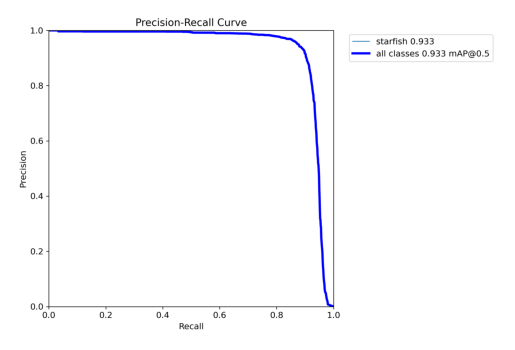

In [4]:
# plots results for yolov10m

import pandas as pd
rec_pre = Image.open(r"./runs/detect/train/PR_curve.png")
fig, ax = plt.subplots()
ax.imshow(rec_pre)
ax.axis('off')
ax.spines['top'].set_visible(False)
ax.spines['right'].set_visible(False)
ax.spines['bottom'].set_visible(False)
ax.spines['left'].set_visible(False)
plt.show()

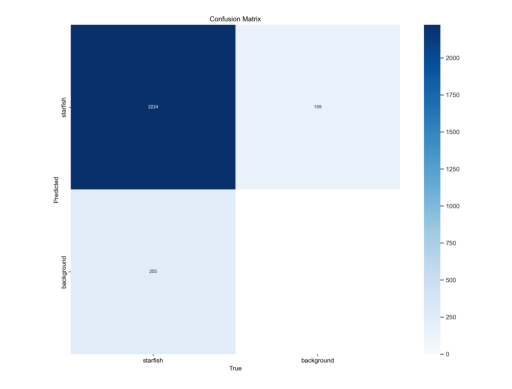

In [53]:
conf_mat = Image.open(r"./runs/detect/train/confusion_matrix.png")
fig, ax = plt.subplots()
ax.imshow(conf_mat)
ax.axis('off')
ax.spines['top'].set_visible(False)
ax.spines['right'].set_visible(False)
ax.spines['bottom'].set_visible(False)
ax.spines['left'].set_visible(False)
plt.show()

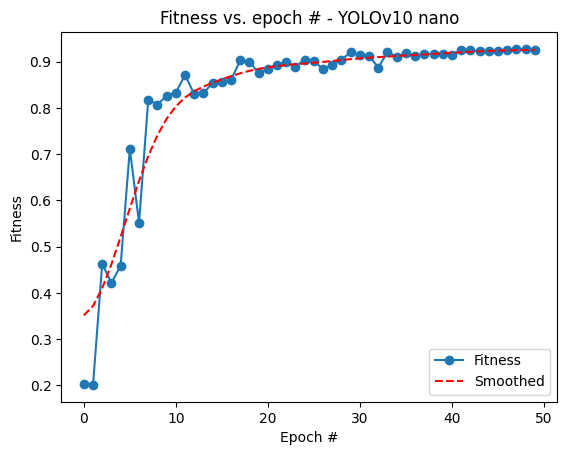

In [39]:
# Plotting the Training fitness epoch-wise

from scipy.ndimage import gaussian_filter1d
results_n = pd.read_csv(r"./runs/detect/train/results.csv")
# results_n.axes[1] # show different key names
recall = results_n[results_n.axes[1][7]] 
map50 = results_n[results_n.axes[1][8]]
map5095 = results_n[results_n.axes[1][9]]
fitness = 0.2 * recall + 0.2 * map50 + 0.6 * map5095
fitness_smoothed = gaussian_filter1d(fitness, sigma=3) # Create a smoothed version of the training process
plt.plot(fitness, "-o", label="Fitness")
plt.plot(fitness_smoothed, "r--", label="Smoothed")
plt.title("Fitness vs. epoch # - YOLOv10 nano")
plt.xlabel("Epoch #")
plt.ylabel("Fitness")
plt.legend()

In [14]:
# Training the YOLOv10 Medium model

model_m = YOLOv10(model=r"weights\yolov10m.pt")
results_m = model_m.train(
data=DATASET_PATH + 'data.yaml',
plots = True,
epochs=50,
imgsz=640,
batch=10, # Changed batch_size according to memory limitations
lr0=0.0016,
momentum=0.875,
weight_decay=0.0005,
optimizer='Adam',
patience=10,
augment= False, 
hsv_h= 0,
hsv_s= 0,
hsv_v= 0,
degrees=0.0,
translate= 0,
scale= 0,
shear= 0,
perspective= 0,
flipud= 0,
fliplr= 0,
mosaic= 0,
mixup= 0,
erasing= 0.0,
crop_fraction=0.0,
)

New https://pypi.org/project/ultralytics/8.2.75 available 😃 Update with 'pip install -U ultralytics'
Ultralytics YOLOv8.1.34 🚀 Python-3.12.4 torch-2.3.0+cu121 CUDA:0 (NVIDIA GeForce GTX 1080, 8192MiB)
engine\trainer: task=detect, mode=train, model=weights\yolov10m.pt, data=h:\python_projects\deep_learning_technion\project\Starfish-Object-detection/datasets/Great-Barrier-Reef-5/data.yaml, epochs=50, time=None, patience=10, batch=10, imgsz=640, save=True, save_period=-1, val_period=1, cache=False, device=None, workers=8, project=None, name=train2, exist_ok=False, pretrained=True, optimizer=Adam, verbose=True, seed=0, deterministic=True, single_cls=False, rect=False, cos_lr=False, close_mosaic=10, resume=False, amp=True, fraction=1.0, profile=False, freeze=None, multi_scale=False, overlap_mask=True, mask_ratio=4, dropout=0.0, val=True, split=val, save_json=False, save_hybrid=False, conf=None, iou=0.7, max_det=300, half=False, dnn=False, plots=True, source=None, vid_stride=1, stream_buffer

train: Scanning H:\python_projects\deep_learning_technion\project\Starfish-Object-detection\datasets\Great-Barrier-Reef-5\train\labels.cache... 3438 images, 0 backgrounds, 0 corrupt: 100%|██████████| 3438/3438 [00:00<?, ?it/s]
val: Scanning H:\python_projects\deep_learning_technion\project\Starfish-Object-detection\datasets\Great-Barrier-Reef-5\valid\labels.cache... 983 images, 0 backgrounds, 0 corrupt: 100%|██████████| 983/983 [00:00<?, ?it/s]


Plotting labels to runs\detect\train2\labels.jpg... 
optimizer: Adam(lr=0.0016, momentum=0.875) with parameter groups 129 weight(decay=0.0), 142 weight(decay=0.00046875), 141 bias(decay=0.0)
TensorBoard: model graph visualization added ✅
Image sizes 640 train, 640 val
Using 4 dataloader workers
Logging results to runs\detect\train2
Starting training for 50 epochs...

      Epoch    GPU_mem     box_om     cls_om     dfl_om     box_oo     cls_oo     dfl_oo  Instances       Size


  0%|          | 0/344 [00:00<?, ?it/s]c:\Users\Itai\AppData\Local\Programs\Python\Python312\Lib\site-packages\torch\autograd\graph.py:744: UserWarning: Plan failed with a cudnnException: CUDNN_BACKEND_EXECUTION_PLAN_DESCRIPTOR: cudnnFinalize Descriptor Failed cudnn_status: CUDNN_STATUS_NOT_SUPPORTED (Triggered internally at ..\aten\src\ATen\native\cudnn\Conv_v8.cpp:919.)
  return Variable._execution_engine.run_backward(  # Calls into the C++ engine to run the backward pass
       1/50      10.6G      2.094      2.375      1.419      2.101      3.134      1.358          9        640: 100%|██████████| 344/344 [31:22<00:00,  5.47s/it]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 50/50 [03:00<00:00,  3.61s/it]


                   all        983       2479      0.523      0.363      0.367      0.169

      Epoch    GPU_mem     box_om     cls_om     dfl_om     box_oo     cls_oo     dfl_oo  Instances       Size


       2/50      7.64G      1.678      1.162      1.197      1.781      1.289        1.2         29        640: 100%|██████████| 344/344 [15:46<00:00,  2.75s/it]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 50/50 [02:09<00:00,  2.59s/it]


                   all        983       2479      0.694      0.547        0.6      0.289

      Epoch    GPU_mem     box_om     cls_om     dfl_om     box_oo     cls_oo     dfl_oo  Instances       Size


       3/50      7.64G      1.533     0.9005      1.134      1.643     0.9205      1.142         15        640: 100%|██████████| 344/344 [12:50<00:00,  2.24s/it]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 50/50 [02:06<00:00,  2.54s/it]


                   all        983       2479      0.747      0.505       0.58       0.31

      Epoch    GPU_mem     box_om     cls_om     dfl_om     box_oo     cls_oo     dfl_oo  Instances       Size


       4/50      7.65G      1.426     0.7696      1.091      1.527     0.7436      1.099         14        640: 100%|██████████| 344/344 [08:45<00:00,  1.53s/it]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 50/50 [01:44<00:00,  2.08s/it]


                   all        983       2479      0.835      0.718      0.802      0.438

      Epoch    GPU_mem     box_om     cls_om     dfl_om     box_oo     cls_oo     dfl_oo  Instances       Size


       5/50      7.64G      1.307     0.6646      1.046      1.407     0.6088      1.057         14        640: 100%|██████████| 344/344 [09:23<00:00,  1.64s/it]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 50/50 [01:39<00:00,  1.99s/it]


                   all        983       2479      0.813      0.651      0.761      0.443

      Epoch    GPU_mem     box_om     cls_om     dfl_om     box_oo     cls_oo     dfl_oo  Instances       Size


       6/50      7.66G      1.205     0.5762      1.012      1.303       0.48      1.022         18        640: 100%|██████████| 344/344 [06:58<00:00,  1.22s/it]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 50/50 [01:06<00:00,  1.33s/it]


                   all        983       2479      0.852      0.744      0.831      0.481

      Epoch    GPU_mem     box_om     cls_om     dfl_om     box_oo     cls_oo     dfl_oo  Instances       Size


       7/50      7.67G      1.126     0.5446     0.9838      1.218     0.4303     0.9923         18        640: 100%|██████████| 344/344 [06:50<00:00,  1.19s/it]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 50/50 [01:06<00:00,  1.33s/it]


                   all        983       2479      0.905       0.84      0.909      0.545

      Epoch    GPU_mem     box_om     cls_om     dfl_om     box_oo     cls_oo     dfl_oo  Instances       Size


       8/50      7.66G      1.077     0.5117     0.9654      1.158     0.3947     0.9706         21        640: 100%|██████████| 344/344 [07:05<00:00,  1.24s/it]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 50/50 [01:07<00:00,  1.34s/it]


                   all        983       2479      0.922      0.862      0.926      0.564

      Epoch    GPU_mem     box_om     cls_om     dfl_om     box_oo     cls_oo     dfl_oo  Instances       Size


       9/50      7.64G     0.9869      0.463     0.9385      1.071     0.3439     0.9446         16        640: 100%|██████████| 344/344 [07:14<00:00,  1.26s/it]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 50/50 [00:36<00:00,  1.35it/s]


                   all        983       2479      0.941      0.876      0.934      0.563

      Epoch    GPU_mem     box_om     cls_om     dfl_om     box_oo     cls_oo     dfl_oo  Instances       Size


      10/50      7.64G     0.9474     0.4425     0.9228      1.031     0.3297     0.9295         10        640: 100%|██████████| 344/344 [05:30<00:00,  1.04it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 50/50 [00:33<00:00,  1.49it/s]


                   all        983       2479      0.937      0.865      0.928      0.572

      Epoch    GPU_mem     box_om     cls_om     dfl_om     box_oo     cls_oo     dfl_oo  Instances       Size


      11/50      7.65G     0.8966      0.416     0.9056     0.9691     0.2987     0.9089         30        640: 100%|██████████| 344/344 [05:28<00:00,  1.05it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 50/50 [00:33<00:00,  1.48it/s]


                   all        983       2479      0.929      0.873       0.92      0.568

      Epoch    GPU_mem     box_om     cls_om     dfl_om     box_oo     cls_oo     dfl_oo  Instances       Size


      12/50      7.64G     0.8351      0.393     0.8881      0.904     0.2859     0.8925         19        640: 100%|██████████| 344/344 [07:17<00:00,  1.27s/it]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 50/50 [00:36<00:00,  1.35it/s]


                   all        983       2479      0.957      0.868      0.932      0.591

      Epoch    GPU_mem     box_om     cls_om     dfl_om     box_oo     cls_oo     dfl_oo  Instances       Size


      13/50      7.64G     0.8002     0.3777     0.8785     0.8625     0.2684     0.8807         15        640: 100%|██████████| 344/344 [15:11<00:00,  2.65s/it]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 50/50 [02:23<00:00,  2.86s/it]


                   all        983       2479       0.93      0.878      0.922      0.584

      Epoch    GPU_mem     box_om     cls_om     dfl_om     box_oo     cls_oo     dfl_oo  Instances       Size


      14/50      7.68G     0.7689     0.3713      0.868      0.832     0.2614     0.8719         18        640: 100%|██████████| 344/344 [16:27<00:00,  2.87s/it]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 50/50 [02:14<00:00,  2.70s/it]


                   all        983       2479      0.931       0.85      0.925      0.583

      Epoch    GPU_mem     box_om     cls_om     dfl_om     box_oo     cls_oo     dfl_oo  Instances       Size


      15/50      7.68G     0.7096     0.3428     0.8535     0.7713     0.2336      0.856         11        640: 100%|██████████| 344/344 [11:40<00:00,  2.04s/it]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 50/50 [02:15<00:00,  2.72s/it]


                   all        983       2479      0.939      0.837      0.903       0.58

      Epoch    GPU_mem     box_om     cls_om     dfl_om     box_oo     cls_oo     dfl_oo  Instances       Size


      16/50      7.64G     0.6681     0.3264     0.8437      0.722     0.2219     0.8445         13        640: 100%|██████████| 344/344 [09:22<00:00,  1.64s/it]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 50/50 [01:47<00:00,  2.15s/it]


                   all        983       2479      0.948      0.875      0.931      0.592

      Epoch    GPU_mem     box_om     cls_om     dfl_om     box_oo     cls_oo     dfl_oo  Instances       Size


      17/50      7.64G     0.6475     0.3172     0.8365     0.7004     0.2167     0.8386         28        640: 100%|██████████| 344/344 [10:13<00:00,  1.78s/it]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 50/50 [01:46<00:00,  2.13s/it]


                   all        983       2479      0.918      0.831      0.901      0.588

      Epoch    GPU_mem     box_om     cls_om     dfl_om     box_oo     cls_oo     dfl_oo  Instances       Size


      18/50      7.64G     0.6142     0.3029     0.8291     0.6666     0.2031     0.8319         21        640: 100%|██████████| 344/344 [10:48<00:00,  1.89s/it]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 50/50 [01:41<00:00,  2.03s/it]


                   all        983       2479       0.94      0.837      0.913      0.595

      Epoch    GPU_mem     box_om     cls_om     dfl_om     box_oo     cls_oo     dfl_oo  Instances       Size


      19/50      7.64G      0.579     0.2917      0.821     0.6337     0.2001     0.8242         19        640: 100%|██████████| 344/344 [08:50<00:00,  1.54s/it]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 50/50 [01:01<00:00,  1.23s/it]


                   all        983       2479      0.946      0.894      0.941      0.616

      Epoch    GPU_mem     box_om     cls_om     dfl_om     box_oo     cls_oo     dfl_oo  Instances       Size


      20/50      7.68G     0.5459       0.28     0.8143     0.5932     0.1817     0.8157          8        640: 100%|██████████| 344/344 [11:07<00:00,  1.94s/it]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 50/50 [01:44<00:00,  2.09s/it]


                   all        983       2479      0.948      0.881       0.94      0.615

      Epoch    GPU_mem     box_om     cls_om     dfl_om     box_oo     cls_oo     dfl_oo  Instances       Size


      21/50      7.66G     0.5298     0.2725     0.8117     0.5751     0.1778     0.8128         24        640: 100%|██████████| 344/344 [08:30<00:00,  1.48s/it]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 50/50 [01:24<00:00,  1.68s/it]


                   all        983       2479      0.908      0.821      0.896      0.592

      Epoch    GPU_mem     box_om     cls_om     dfl_om     box_oo     cls_oo     dfl_oo  Instances       Size


      22/50      7.63G     0.4979     0.2606     0.8056     0.5428     0.1706      0.807         15        640: 100%|██████████| 344/344 [11:21<00:00,  1.98s/it]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 50/50 [01:57<00:00,  2.35s/it]


                   all        983       2479      0.918      0.825      0.899       0.59

      Epoch    GPU_mem     box_om     cls_om     dfl_om     box_oo     cls_oo     dfl_oo  Instances       Size


      23/50      7.66G     0.5072     0.2646     0.8055     0.5506     0.1701     0.8072         27        640: 100%|██████████| 344/344 [11:36<00:00,  2.02s/it]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 50/50 [01:56<00:00,  2.32s/it]


                   all        983       2479       0.94      0.879      0.932      0.614

      Epoch    GPU_mem     box_om     cls_om     dfl_om     box_oo     cls_oo     dfl_oo  Instances       Size


      24/50      7.64G     0.4692     0.2483     0.7999      0.514     0.1553     0.8015         13        640: 100%|██████████| 344/344 [11:08<00:00,  1.94s/it]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 50/50 [01:52<00:00,  2.24s/it]


                   all        983       2479      0.946      0.878      0.929      0.612

      Epoch    GPU_mem     box_om     cls_om     dfl_om     box_oo     cls_oo     dfl_oo  Instances       Size


      25/50      7.64G     0.4668     0.2461     0.8001     0.5052     0.1522     0.8007         13        640: 100%|██████████| 344/344 [13:30<00:00,  2.36s/it]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 50/50 [02:10<00:00,  2.61s/it]


                   all        983       2479      0.956      0.889      0.938      0.619

      Epoch    GPU_mem     box_om     cls_om     dfl_om     box_oo     cls_oo     dfl_oo  Instances       Size


      26/50      7.68G     0.4465     0.2386     0.7966     0.4799     0.1475     0.7969         12        640: 100%|██████████| 344/344 [18:03<00:00,  3.15s/it]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 50/50 [02:33<00:00,  3.06s/it]


                   all        983       2479      0.955      0.874      0.929      0.614

      Epoch    GPU_mem     box_om     cls_om     dfl_om     box_oo     cls_oo     dfl_oo  Instances       Size


      27/50      7.64G     0.4298     0.2306     0.7933     0.4677     0.1437     0.7938          9        640: 100%|██████████| 344/344 [13:35<00:00,  2.37s/it]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 50/50 [02:18<00:00,  2.76s/it]


                   all        983       2479      0.968      0.875      0.939      0.621

      Epoch    GPU_mem     box_om     cls_om     dfl_om     box_oo     cls_oo     dfl_oo  Instances       Size


      28/50      7.64G     0.4087     0.2252     0.7901     0.4449       0.14     0.7906         33        640: 100%|██████████| 344/344 [16:52<00:00,  2.94s/it]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 50/50 [02:46<00:00,  3.32s/it]


                   all        983       2479      0.968      0.869      0.936      0.619

      Epoch    GPU_mem     box_om     cls_om     dfl_om     box_oo     cls_oo     dfl_oo  Instances       Size


      29/50      7.67G      0.398      0.218     0.7874     0.4349     0.1372     0.7883         16        640: 100%|██████████| 344/344 [18:48<00:00,  3.28s/it]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 50/50 [02:38<00:00,  3.18s/it]


                   all        983       2479      0.953      0.891      0.941      0.625

      Epoch    GPU_mem     box_om     cls_om     dfl_om     box_oo     cls_oo     dfl_oo  Instances       Size


      30/50      7.64G     0.3763      0.209     0.7842     0.4124     0.1289     0.7847         14        640: 100%|██████████| 344/344 [13:36<00:00,  2.37s/it]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 50/50 [02:18<00:00,  2.76s/it]


                   all        983       2479      0.958      0.891      0.935      0.621

      Epoch    GPU_mem     box_om     cls_om     dfl_om     box_oo     cls_oo     dfl_oo  Instances       Size


      31/50      7.64G     0.3605     0.2046      0.783     0.3947     0.1275     0.7837         49        640: 100%|██████████| 344/344 [16:31<00:00,  2.88s/it]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 50/50 [02:43<00:00,  3.27s/it]


                   all        983       2479      0.953      0.883      0.929      0.616

      Epoch    GPU_mem     box_om     cls_om     dfl_om     box_oo     cls_oo     dfl_oo  Instances       Size


      32/50      7.64G     0.3523        0.2     0.7815     0.3816      0.122     0.7814         21        640: 100%|██████████| 344/344 [17:17<00:00,  3.01s/it]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 50/50 [02:38<00:00,  3.16s/it]


                   all        983       2479      0.959       0.89      0.944      0.622

      Epoch    GPU_mem     box_om     cls_om     dfl_om     box_oo     cls_oo     dfl_oo  Instances       Size


      33/50      7.64G     0.3499     0.1972     0.7811     0.3787     0.1196     0.7807         13        640: 100%|██████████| 344/344 [13:45<00:00,  2.40s/it]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 50/50 [02:19<00:00,  2.80s/it]


                   all        983       2479      0.961      0.904      0.943       0.63

      Epoch    GPU_mem     box_om     cls_om     dfl_om     box_oo     cls_oo     dfl_oo  Instances       Size


      34/50      7.64G     0.3265     0.1891     0.7777     0.3521     0.1129     0.7772         11        640: 100%|██████████| 344/344 [16:44<00:00,  2.92s/it]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 50/50 [02:46<00:00,  3.33s/it]


                   all        983       2479      0.965      0.884      0.938      0.626

      Epoch    GPU_mem     box_om     cls_om     dfl_om     box_oo     cls_oo     dfl_oo  Instances       Size


      35/50      7.65G     0.3177     0.1843     0.7766     0.3408     0.1096     0.7759         25        640: 100%|██████████| 344/344 [17:35<00:00,  3.07s/it]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 50/50 [02:37<00:00,  3.16s/it]


                   all        983       2479      0.958      0.885       0.94      0.625

      Epoch    GPU_mem     box_om     cls_om     dfl_om     box_oo     cls_oo     dfl_oo  Instances       Size


      36/50      7.64G     0.3025     0.1787     0.7754     0.3278     0.1054     0.7749         25        640: 100%|██████████| 344/344 [11:35<00:00,  2.02s/it]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 50/50 [01:50<00:00,  2.21s/it]


                   all        983       2479      0.969      0.881      0.928      0.619

      Epoch    GPU_mem     box_om     cls_om     dfl_om     box_oo     cls_oo     dfl_oo  Instances       Size


      37/50      7.64G     0.2903     0.1737     0.7738     0.3124     0.1022     0.7736         11        640: 100%|██████████| 344/344 [16:34<00:00,  2.89s/it]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 50/50 [02:30<00:00,  3.00s/it]


                   all        983       2479      0.966      0.898      0.948      0.635

      Epoch    GPU_mem     box_om     cls_om     dfl_om     box_oo     cls_oo     dfl_oo  Instances       Size


      38/50      7.64G     0.2747     0.1665     0.7725     0.2981    0.09901      0.772         27        640: 100%|██████████| 344/344 [17:14<00:00,  3.01s/it]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 50/50 [02:30<00:00,  3.00s/it]


                   all        983       2479      0.961      0.887      0.938      0.629

      Epoch    GPU_mem     box_om     cls_om     dfl_om     box_oo     cls_oo     dfl_oo  Instances       Size


      39/50      7.64G     0.2657     0.1627     0.7707     0.2873    0.09421     0.7702         37        640: 100%|██████████| 344/344 [14:33<00:00,  2.54s/it]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 50/50 [02:32<00:00,  3.05s/it]


                   all        983       2479      0.971      0.894       0.94       0.63

      Epoch    GPU_mem     box_om     cls_om     dfl_om     box_oo     cls_oo     dfl_oo  Instances       Size


      40/50      7.65G     0.2507     0.1561     0.7695     0.2726    0.09021      0.769         35        640: 100%|██████████| 344/344 [16:55<00:00,  2.95s/it]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 50/50 [01:53<00:00,  2.27s/it]


                   all        983       2479      0.976       0.89      0.948      0.637
Closing dataloader mosaic

      Epoch    GPU_mem     box_om     cls_om     dfl_om     box_oo     cls_oo     dfl_oo  Instances       Size


      41/50      7.65G     0.2347     0.1496      0.768     0.2551    0.08584     0.7678         12        640: 100%|██████████| 344/344 [14:22<00:00,  2.51s/it]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 50/50 [02:51<00:00,  3.42s/it]


                   all        983       2479      0.975      0.893      0.944      0.633

      Epoch    GPU_mem     box_om     cls_om     dfl_om     box_oo     cls_oo     dfl_oo  Instances       Size


      42/50      7.68G     0.2193     0.1431     0.7678     0.2376    0.08258     0.7669         27        640: 100%|██████████| 344/344 [11:38<00:00,  2.03s/it]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 50/50 [02:52<00:00,  3.44s/it]


                   all        983       2479      0.972      0.897      0.948      0.638

      Epoch    GPU_mem     box_om     cls_om     dfl_om     box_oo     cls_oo     dfl_oo  Instances       Size


      43/50      7.65G     0.2065     0.1372     0.7666     0.2234    0.07697     0.7663         26        640: 100%|██████████| 344/344 [09:29<00:00,  1.65s/it]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 50/50 [01:15<00:00,  1.52s/it]


                   all        983       2479      0.962      0.903      0.947      0.636

      Epoch    GPU_mem     box_om     cls_om     dfl_om     box_oo     cls_oo     dfl_oo  Instances       Size


      44/50      7.63G     0.2008      0.134     0.7652     0.2158    0.07582     0.7646         11        640: 100%|██████████| 344/344 [18:07<00:00,  3.16s/it]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 50/50 [02:28<00:00,  2.97s/it]


                   all        983       2479      0.975      0.901      0.949      0.638

      Epoch    GPU_mem     box_om     cls_om     dfl_om     box_oo     cls_oo     dfl_oo  Instances       Size


      45/50      7.66G     0.1872     0.1283     0.7641     0.2017    0.07133     0.7635         25        640: 100%|██████████| 344/344 [12:31<00:00,  2.18s/it]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 50/50 [02:39<00:00,  3.19s/it]


                   all        983       2479      0.967      0.901      0.949       0.64

      Epoch    GPU_mem     box_om     cls_om     dfl_om     box_oo     cls_oo     dfl_oo  Instances       Size


      46/50      7.63G     0.1729     0.1216     0.7635     0.1866    0.06628     0.7632         27        640: 100%|██████████| 344/344 [13:43<00:00,  2.39s/it]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 50/50 [02:29<00:00,  2.99s/it]


                   all        983       2479      0.977      0.904      0.952      0.641

      Epoch    GPU_mem     box_om     cls_om     dfl_om     box_oo     cls_oo     dfl_oo  Instances       Size


      47/50      7.65G     0.1638     0.1155     0.7631      0.176    0.06304     0.7626         15        640: 100%|██████████| 344/344 [15:37<00:00,  2.73s/it]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 50/50 [02:51<00:00,  3.43s/it]


                   all        983       2479      0.969      0.907      0.952      0.641

      Epoch    GPU_mem     box_om     cls_om     dfl_om     box_oo     cls_oo     dfl_oo  Instances       Size


      48/50      7.69G     0.1547     0.1113     0.7623     0.1643    0.05962     0.7617         11        640: 100%|██████████| 344/344 [15:12<00:00,  2.65s/it]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 50/50 [02:52<00:00,  3.45s/it]


                   all        983       2479       0.97      0.902      0.951       0.64

      Epoch    GPU_mem     box_om     cls_om     dfl_om     box_oo     cls_oo     dfl_oo  Instances       Size


      49/50      7.67G     0.1443     0.1065     0.7624     0.1546    0.05658     0.7617         12        640: 100%|██████████| 344/344 [15:54<00:00,  2.78s/it]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 50/50 [02:36<00:00,  3.13s/it]


                   all        983       2479      0.967      0.911      0.952       0.64

      Epoch    GPU_mem     box_om     cls_om     dfl_om     box_oo     cls_oo     dfl_oo  Instances       Size


      50/50      7.64G     0.1367     0.1025     0.7614     0.1454    0.05464     0.7607         15        640: 100%|██████████| 344/344 [10:45<00:00,  1.88s/it]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 50/50 [02:08<00:00,  2.57s/it]


                   all        983       2479      0.975        0.9      0.952      0.642

50 epochs completed in 12.653 hours.
Optimizer stripped from runs\detect\train2\weights\last.pt, 33.5MB
Optimizer stripped from runs\detect\train2\weights\best.pt, 33.5MB

Validating runs\detect\train2\weights\best.pt...
Ultralytics YOLOv8.1.34 🚀 Python-3.12.4 torch-2.3.0+cu121 CUDA:0 (NVIDIA GeForce GTX 1080, 8192MiB)
YOLOv10m summary (fused): 369 layers, 16451542 parameters, 0 gradients, 63.4 GFLOPs


                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 50/50 [00:28<00:00,  1.78it/s]


                   all        983       2479      0.975      0.901      0.952      0.642
Speed: 0.4ms preprocess, 22.2ms inference, 0.0ms loss, 0.3ms postprocess per image
Results saved to runs\detect\train2


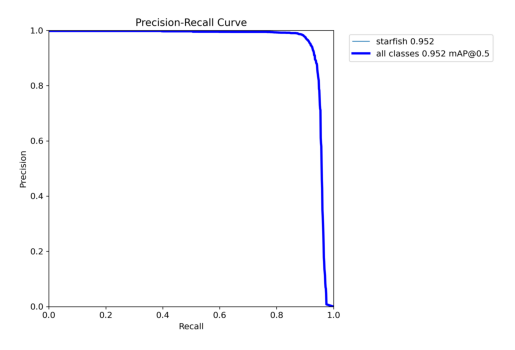

In [29]:
# plots results for yolov10m

rec_pre = Image.open(r"./runs/detect/train2/PR_curve.png")
fig, ax = plt.subplots()
ax.imshow(rec_pre)
ax.axis('off')
ax.spines['top'].set_visible(False)
ax.spines['right'].set_visible(False)
ax.spines['bottom'].set_visible(False)
ax.spines['left'].set_visible(False)
plt.show()

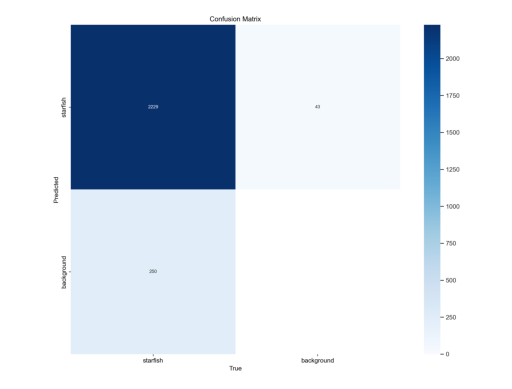

In [54]:
conf_mat = Image.open(r"./runs/detect/train2/confusion_matrix.png")
fig, ax = plt.subplots()
ax.imshow(conf_mat)
ax.axis('off')
ax.spines['top'].set_visible(False)
ax.spines['right'].set_visible(False)
ax.spines['bottom'].set_visible(False)
ax.spines['left'].set_visible(False)
plt.show()

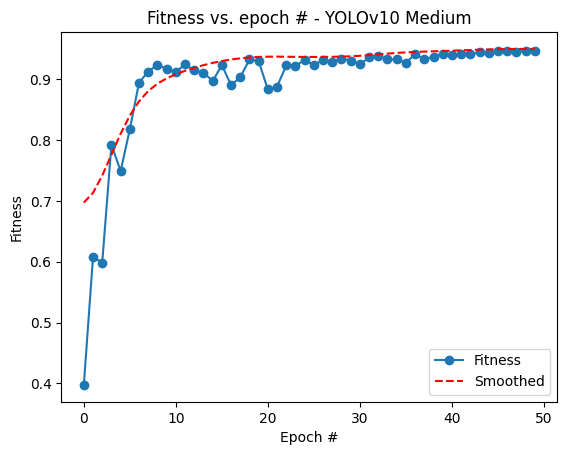

In [34]:
# Plotting the Training fitness epoch-wise

results_m = pd.read_csv(r"./runs/detect/train2/results.csv")
# results_n.axes[1] # show different key names
recall = results_m[results_n.axes[1][7]] 
map50 = results_m[results_n.axes[1][8]]
map5095 = results_m[results_n.axes[1][9]]
fitness_m = 0.2 * recall + 0.2 * map50 + 0.6 * map5095
fitness_smoothed_m = gaussian_filter1d(fitness, sigma=3) # Create a smoothed version of the training process
plt.plot(fitness_m, "-o", label="Fitness")
plt.plot(fitness_smoothed_m, "r--", label="Smoothed")
plt.title("Fitness vs. epoch # - YOLOv10 Medium")
plt.xlabel("Epoch #")
plt.ylabel("Fitness")
plt.legend()

In [15]:
# Training the YOLOv10 Large model

model_l = YOLOv10(model=r"weights\yolov10l.pt")
results_l = model_l.train(
data=DATASET_PATH + 'data.yaml',
plots = True,
epochs=50,
imgsz=640,
batch=4, # Changed batch_size according to memory limitations
lr0=0.0016,
momentum=0.875,
weight_decay=0.0005,
optimizer='Adam',
patience=10,
augment= False, 
hsv_h= 0,
hsv_s= 0,
hsv_v= 0,
degrees=0.0,
translate= 0,
scale= 0,
shear= 0,
perspective= 0,
flipud= 0,
fliplr= 0,
mosaic= 0,
mixup= 0,
erasing= 0.0,
crop_fraction=0.0,
)

New https://pypi.org/project/ultralytics/8.2.75 available 😃 Update with 'pip install -U ultralytics'
Ultralytics YOLOv8.1.34 🚀 Python-3.12.4 torch-2.3.0+cu121 CUDA:0 (NVIDIA GeForce GTX 1080, 8192MiB)
engine\trainer: task=detect, mode=train, model=weights\yolov10l.pt, data=h:\python_projects\deep_learning_technion\project\Starfish-Object-detection/datasets/Great-Barrier-Reef-5/data.yaml, epochs=50, time=None, patience=10, batch=4, imgsz=640, save=True, save_period=-1, val_period=1, cache=False, device=None, workers=8, project=None, name=train3, exist_ok=False, pretrained=True, optimizer=Adam, verbose=True, seed=0, deterministic=True, single_cls=False, rect=False, cos_lr=False, close_mosaic=10, resume=False, amp=True, fraction=1.0, profile=False, freeze=None, multi_scale=False, overlap_mask=True, mask_ratio=4, dropout=0.0, val=True, split=val, save_json=False, save_hybrid=False, conf=None, iou=0.7, max_det=300, half=False, dnn=False, plots=True, source=None, vid_stride=1, stream_buffer=

train: Scanning H:\python_projects\deep_learning_technion\project\Starfish-Object-detection\datasets\Great-Barrier-Reef-5\train\labels.cache... 3438 images, 0 backgrounds, 0 corrupt: 100%|██████████| 3438/3438 [00:00<?, ?it/s]
val: Scanning H:\python_projects\deep_learning_technion\project\Starfish-Object-detection\datasets\Great-Barrier-Reef-5\valid\labels.cache... 983 images, 0 backgrounds, 0 corrupt: 100%|██████████| 983/983 [00:00<?, ?it/s]


Plotting labels to runs\detect\train3\labels.jpg... 
optimizer: Adam(lr=0.0016, momentum=0.875) with parameter groups 167 weight(decay=0.0), 180 weight(decay=0.0005), 179 bias(decay=0.0)
TensorBoard: model graph visualization added ✅
Image sizes 640 train, 640 val
Using 4 dataloader workers
Logging results to runs\detect\train3
Starting training for 50 epochs...

      Epoch    GPU_mem     box_om     cls_om     dfl_om     box_oo     cls_oo     dfl_oo  Instances       Size


  0%|          | 0/860 [00:00<?, ?it/s]c:\Users\Itai\AppData\Local\Programs\Python\Python312\Lib\site-packages\torch\autograd\graph.py:744: UserWarning: Plan failed with a cudnnException: CUDNN_BACKEND_EXECUTION_PLAN_DESCRIPTOR: cudnnFinalize Descriptor Failed cudnn_status: CUDNN_STATUS_NOT_SUPPORTED (Triggered internally at ..\aten\src\ATen\native\cudnn\Conv_v8.cpp:919.)
  return Variable._execution_engine.run_backward(  # Calls into the C++ engine to run the backward pass
       1/50       5.2G      2.157      2.459      1.435      2.155      2.959      1.386          3        640: 100%|██████████| 860/860 [07:07<00:00,  2.01it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95):  99%|█████████▉| 122/123 [00:44<00:00,  2.71it/s]c:\Users\Itai\AppData\Local\Programs\Python\Python312\Lib\site-packages\torch\nn\modules\conv.py:456: UserWarning: Plan failed with a cudnnException: CUDNN_BACKEND_EXECUTION_PLAN_DESCRIPTOR: cudnnFinalize Descriptor Fail

                   all        983       2479      0.585      0.348      0.385      0.181

      Epoch    GPU_mem     box_om     cls_om     dfl_om     box_oo     cls_oo     dfl_oo  Instances       Size


       2/50      4.96G      1.755      1.377      1.225      1.849      1.493      1.229          8        640: 100%|██████████| 860/860 [06:52<00:00,  2.09it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 123/123 [00:45<00:00,  2.70it/s]


                   all        983       2479      0.819      0.639      0.732      0.368

      Epoch    GPU_mem     box_om     cls_om     dfl_om     box_oo     cls_oo     dfl_oo  Instances       Size


       3/50      4.95G      1.566     0.9892      1.144      1.676     0.9946      1.159          4        640: 100%|██████████| 860/860 [06:49<00:00,  2.10it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 123/123 [00:45<00:00,  2.70it/s]


                   all        983       2479      0.812      0.693      0.782      0.406

      Epoch    GPU_mem     box_om     cls_om     dfl_om     box_oo     cls_oo     dfl_oo  Instances       Size


       4/50      4.94G      1.431     0.7879      1.088      1.532     0.7408      1.095          2        640: 100%|██████████| 860/860 [06:49<00:00,  2.10it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 123/123 [00:45<00:00,  2.69it/s]


                   all        983       2479      0.866      0.732       0.82       0.44

      Epoch    GPU_mem     box_om     cls_om     dfl_om     box_oo     cls_oo     dfl_oo  Instances       Size


       5/50      4.94G      1.331     0.6836      1.054      1.424     0.6066      1.062          3        640: 100%|██████████| 860/860 [06:49<00:00,  2.10it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 123/123 [00:45<00:00,  2.69it/s]


                   all        983       2479      0.912       0.82      0.889      0.495

      Epoch    GPU_mem     box_om     cls_om     dfl_om     box_oo     cls_oo     dfl_oo  Instances       Size


       6/50      4.96G      1.227     0.5974      1.017      1.321     0.4946      1.028          8        640: 100%|██████████| 860/860 [06:49<00:00,  2.10it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 123/123 [00:45<00:00,  2.69it/s]


                   all        983       2479      0.898      0.835      0.902      0.524

      Epoch    GPU_mem     box_om     cls_om     dfl_om     box_oo     cls_oo     dfl_oo  Instances       Size


       7/50      4.96G      1.149     0.5577     0.9883      1.234     0.4583      0.996          5        640: 100%|██████████| 860/860 [06:49<00:00,  2.10it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 123/123 [00:45<00:00,  2.69it/s]


                   all        983       2479      0.922       0.85      0.914      0.549

      Epoch    GPU_mem     box_om     cls_om     dfl_om     box_oo     cls_oo     dfl_oo  Instances       Size


       8/50      4.96G      1.067     0.5121     0.9608      1.145     0.3993     0.9661          6        640: 100%|██████████| 860/860 [06:48<00:00,  2.10it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 123/123 [00:45<00:00,  2.69it/s]


                   all        983       2479      0.926      0.841      0.911      0.545

      Epoch    GPU_mem     box_om     cls_om     dfl_om     box_oo     cls_oo     dfl_oo  Instances       Size


       9/50      4.94G      1.002     0.4717     0.9386       1.08     0.3614     0.9457          4        640: 100%|██████████| 860/860 [06:49<00:00,  2.10it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 123/123 [00:45<00:00,  2.69it/s]


                   all        983       2479       0.94      0.835      0.909      0.558

      Epoch    GPU_mem     box_om     cls_om     dfl_om     box_oo     cls_oo     dfl_oo  Instances       Size


      10/50      4.96G     0.9378     0.4459     0.9198      1.012      0.324     0.9255          4        640: 100%|██████████| 860/860 [06:48<00:00,  2.10it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 123/123 [00:45<00:00,  2.70it/s]


                   all        983       2479      0.923      0.833      0.867      0.543

      Epoch    GPU_mem     box_om     cls_om     dfl_om     box_oo     cls_oo     dfl_oo  Instances       Size


      11/50      4.97G      0.888     0.4127     0.9038     0.9533     0.3067     0.9082         12        640: 100%|██████████| 860/860 [06:49<00:00,  2.10it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 123/123 [00:45<00:00,  2.69it/s]


                   all        983       2479      0.939      0.881      0.938      0.591

      Epoch    GPU_mem     box_om     cls_om     dfl_om     box_oo     cls_oo     dfl_oo  Instances       Size


      12/50      4.95G     0.8436     0.4018      0.888     0.9024     0.2974     0.8892          4        640: 100%|██████████| 860/860 [06:49<00:00,  2.10it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 123/123 [00:45<00:00,  2.69it/s]


                   all        983       2479      0.925      0.883      0.933      0.584

      Epoch    GPU_mem     box_om     cls_om     dfl_om     box_oo     cls_oo     dfl_oo  Instances       Size


      13/50      4.95G     0.7934     0.3786     0.8755     0.8559      0.275     0.8779          2        640: 100%|██████████| 860/860 [06:49<00:00,  2.10it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 123/123 [00:45<00:00,  2.70it/s]


                   all        983       2479      0.938       0.89      0.926      0.587

      Epoch    GPU_mem     box_om     cls_om     dfl_om     box_oo     cls_oo     dfl_oo  Instances       Size


      14/50      4.96G     0.7492     0.3677     0.8633     0.8079     0.2602     0.8671          6        640: 100%|██████████| 860/860 [06:49<00:00,  2.10it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 123/123 [00:45<00:00,  2.68it/s]


                   all        983       2479      0.951      0.884      0.927      0.591

      Epoch    GPU_mem     box_om     cls_om     dfl_om     box_oo     cls_oo     dfl_oo  Instances       Size


      15/50      4.95G     0.7186     0.3519     0.8548     0.7714     0.2467     0.8573          2        640: 100%|██████████| 860/860 [06:48<00:00,  2.10it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 123/123 [00:45<00:00,  2.70it/s]


                   all        983       2479      0.956      0.904      0.937      0.605

      Epoch    GPU_mem     box_om     cls_om     dfl_om     box_oo     cls_oo     dfl_oo  Instances       Size


      16/50      4.95G     0.6803     0.3334     0.8435     0.7303     0.2307     0.8476          2        640: 100%|██████████| 860/860 [06:49<00:00,  2.10it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 123/123 [00:45<00:00,  2.69it/s]


                   all        983       2479      0.946      0.883      0.931        0.6

      Epoch    GPU_mem     box_om     cls_om     dfl_om     box_oo     cls_oo     dfl_oo  Instances       Size


      17/50      4.95G      0.658     0.3255     0.8364      0.708     0.2198     0.8405          2        640: 100%|██████████| 860/860 [06:48<00:00,  2.10it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 123/123 [00:45<00:00,  2.70it/s]


                   all        983       2479      0.959      0.896      0.945      0.611

      Epoch    GPU_mem     box_om     cls_om     dfl_om     box_oo     cls_oo     dfl_oo  Instances       Size


      18/50      4.96G     0.6309     0.3166     0.8302     0.6734      0.211     0.8327          5        640: 100%|██████████| 860/860 [06:49<00:00,  2.10it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 123/123 [00:45<00:00,  2.69it/s]


                   all        983       2479      0.958      0.903       0.95      0.618

      Epoch    GPU_mem     box_om     cls_om     dfl_om     box_oo     cls_oo     dfl_oo  Instances       Size


      19/50      4.95G     0.6004     0.3027     0.8242      0.644     0.1997      0.827          2        640: 100%|██████████| 860/860 [06:48<00:00,  2.10it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 123/123 [00:45<00:00,  2.70it/s]


                   all        983       2479      0.945      0.889      0.943      0.618

      Epoch    GPU_mem     box_om     cls_om     dfl_om     box_oo     cls_oo     dfl_oo  Instances       Size


      20/50      4.95G      0.572     0.2953     0.8166     0.6115      0.193     0.8189          2        640: 100%|██████████| 860/860 [06:48<00:00,  2.10it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 123/123 [00:45<00:00,  2.69it/s]


                   all        983       2479      0.966       0.89      0.946      0.622

      Epoch    GPU_mem     box_om     cls_om     dfl_om     box_oo     cls_oo     dfl_oo  Instances       Size


      21/50      4.95G     0.5416     0.2866     0.8125     0.5839     0.1855     0.8142          2        640: 100%|██████████| 860/860 [06:48<00:00,  2.10it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 123/123 [00:45<00:00,  2.69it/s]


                   all        983       2479      0.971      0.898      0.949      0.621

      Epoch    GPU_mem     box_om     cls_om     dfl_om     box_oo     cls_oo     dfl_oo  Instances       Size


      22/50      4.96G     0.5181     0.2775     0.8079      0.547     0.1726     0.8083          5        640: 100%|██████████| 860/860 [06:48<00:00,  2.10it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 123/123 [00:45<00:00,  2.70it/s]


                   all        983       2479      0.962      0.893      0.942      0.619

      Epoch    GPU_mem     box_om     cls_om     dfl_om     box_oo     cls_oo     dfl_oo  Instances       Size


      23/50      4.96G     0.5231     0.2791     0.8076     0.5536     0.1742     0.8079          6        640: 100%|██████████| 860/860 [06:49<00:00,  2.10it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 123/123 [00:45<00:00,  2.69it/s]


                   all        983       2479       0.96      0.908      0.951      0.624

      Epoch    GPU_mem     box_om     cls_om     dfl_om     box_oo     cls_oo     dfl_oo  Instances       Size


      24/50      4.95G      0.506     0.2714     0.8052     0.5362     0.1664     0.8058          3        640: 100%|██████████| 860/860 [06:48<00:00,  2.10it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 123/123 [00:45<00:00,  2.70it/s]


                   all        983       2479      0.968       0.88      0.936      0.615

      Epoch    GPU_mem     box_om     cls_om     dfl_om     box_oo     cls_oo     dfl_oo  Instances       Size


      25/50      4.95G     0.5012       0.27     0.8039      0.533     0.1655     0.8046          3        640: 100%|██████████| 860/860 [06:48<00:00,  2.10it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 123/123 [00:45<00:00,  2.70it/s]


                   all        983       2479      0.964       0.89      0.924       0.61

      Epoch    GPU_mem     box_om     cls_om     dfl_om     box_oo     cls_oo     dfl_oo  Instances       Size


      26/50      4.95G     0.4786     0.2597     0.8005     0.5106     0.1548     0.8015          3        640: 100%|██████████| 860/860 [06:48<00:00,  2.10it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 123/123 [00:45<00:00,  2.70it/s]


                   all        983       2479      0.968      0.903      0.946      0.623

      Epoch    GPU_mem     box_om     cls_om     dfl_om     box_oo     cls_oo     dfl_oo  Instances       Size


      27/50      4.96G      0.453     0.2524     0.7944     0.4731     0.1477     0.7953          3        640: 100%|██████████| 860/860 [06:48<00:00,  2.10it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 123/123 [00:45<00:00,  2.69it/s]


                   all        983       2479      0.966      0.902      0.943      0.625

      Epoch    GPU_mem     box_om     cls_om     dfl_om     box_oo     cls_oo     dfl_oo  Instances       Size


      28/50      4.95G     0.4375     0.2435     0.7941     0.4616     0.1437     0.7937          2        640: 100%|██████████| 860/860 [06:49<00:00,  2.10it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 123/123 [00:45<00:00,  2.69it/s]


                   all        983       2479      0.958      0.898       0.95       0.63

      Epoch    GPU_mem     box_om     cls_om     dfl_om     box_oo     cls_oo     dfl_oo  Instances       Size


      29/50      4.95G     0.4259     0.2408     0.7906     0.4478     0.1399     0.7898          3        640: 100%|██████████| 860/860 [06:48<00:00,  2.11it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 123/123 [00:45<00:00,  2.70it/s]


                   all        983       2479      0.966      0.899      0.948      0.627

      Epoch    GPU_mem     box_om     cls_om     dfl_om     box_oo     cls_oo     dfl_oo  Instances       Size


      30/50      4.96G     0.4102     0.2367      0.788     0.4325     0.1359     0.7881          4        640: 100%|██████████| 860/860 [06:48<00:00,  2.10it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 123/123 [00:45<00:00,  2.70it/s]


                   all        983       2479      0.981      0.873      0.916      0.611

      Epoch    GPU_mem     box_om     cls_om     dfl_om     box_oo     cls_oo     dfl_oo  Instances       Size


      31/50      4.96G     0.3833     0.2249     0.7842     0.4045     0.1282      0.784         25        640: 100%|██████████| 860/860 [06:48<00:00,  2.10it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 123/123 [00:45<00:00,  2.69it/s]


                   all        983       2479      0.973      0.905      0.939      0.625

      Epoch    GPU_mem     box_om     cls_om     dfl_om     box_oo     cls_oo     dfl_oo  Instances       Size


      32/50      4.95G     0.3768     0.2231     0.7839     0.3926     0.1233     0.7831          9        640: 100%|██████████| 860/860 [06:48<00:00,  2.11it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 123/123 [00:45<00:00,  2.69it/s]


                   all        983       2479      0.972        0.9      0.941      0.629

      Epoch    GPU_mem     box_om     cls_om     dfl_om     box_oo     cls_oo     dfl_oo  Instances       Size


      33/50      4.95G     0.3618     0.2171     0.7822     0.3781     0.1247     0.7816          5        640: 100%|██████████| 860/860 [06:48<00:00,  2.11it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 123/123 [00:45<00:00,  2.70it/s]


                   all        983       2479      0.965       0.91      0.945       0.63

      Epoch    GPU_mem     box_om     cls_om     dfl_om     box_oo     cls_oo     dfl_oo  Instances       Size


      34/50      4.96G     0.3426     0.2082      0.779     0.3569     0.1134     0.7785          5        640: 100%|██████████| 860/860 [06:48<00:00,  2.10it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 123/123 [00:45<00:00,  2.70it/s]


                   all        983       2479      0.967      0.917      0.949      0.634

      Epoch    GPU_mem     box_om     cls_om     dfl_om     box_oo     cls_oo     dfl_oo  Instances       Size


      35/50      4.96G     0.3335     0.2047     0.7776     0.3472     0.1117     0.7763          8        640: 100%|██████████| 860/860 [06:48<00:00,  2.10it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 123/123 [00:45<00:00,  2.70it/s]


                   all        983       2479      0.971      0.907      0.946       0.63

      Epoch    GPU_mem     box_om     cls_om     dfl_om     box_oo     cls_oo     dfl_oo  Instances       Size


      36/50      4.95G     0.3197     0.1984     0.7776     0.3323     0.1105      0.776         13        640: 100%|██████████| 860/860 [06:48<00:00,  2.11it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 123/123 [00:45<00:00,  2.70it/s]


                   all        983       2479      0.969      0.916      0.956      0.639

      Epoch    GPU_mem     box_om     cls_om     dfl_om     box_oo     cls_oo     dfl_oo  Instances       Size


      37/50      4.95G     0.3137     0.1948     0.7758     0.3258     0.1036     0.7746          2        640: 100%|██████████| 860/860 [06:48<00:00,  2.11it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 123/123 [00:45<00:00,  2.70it/s]


                   all        983       2479      0.974      0.904       0.94       0.63

      Epoch    GPU_mem     box_om     cls_om     dfl_om     box_oo     cls_oo     dfl_oo  Instances       Size


      38/50      4.96G     0.3021       0.19     0.7751     0.3109      0.103     0.7739         16        640: 100%|██████████| 860/860 [06:48<00:00,  2.11it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 123/123 [00:45<00:00,  2.70it/s]


                   all        983       2479      0.979      0.901      0.952      0.638

      Epoch    GPU_mem     box_om     cls_om     dfl_om     box_oo     cls_oo     dfl_oo  Instances       Size


      39/50      4.96G     0.2914      0.185     0.7735     0.3006    0.09673     0.7724         16        640: 100%|██████████| 860/860 [06:48<00:00,  2.11it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 123/123 [00:45<00:00,  2.70it/s]


                   all        983       2479      0.972      0.912       0.95      0.637

      Epoch    GPU_mem     box_om     cls_om     dfl_om     box_oo     cls_oo     dfl_oo  Instances       Size


      40/50      4.95G      0.277     0.1768     0.7716     0.2846    0.09405     0.7703          6        640: 100%|██████████| 860/860 [06:48<00:00,  2.10it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 123/123 [00:45<00:00,  2.70it/s]


                   all        983       2479      0.974       0.91      0.951       0.64
Closing dataloader mosaic

      Epoch    GPU_mem     box_om     cls_om     dfl_om     box_oo     cls_oo     dfl_oo  Instances       Size


      41/50      4.95G     0.2626     0.1723     0.7702     0.2685    0.09029      0.769          3        640: 100%|██████████| 860/860 [06:47<00:00,  2.11it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 123/123 [00:45<00:00,  2.70it/s]


                   all        983       2479      0.975      0.907      0.947      0.636

      Epoch    GPU_mem     box_om     cls_om     dfl_om     box_oo     cls_oo     dfl_oo  Instances       Size


      42/50      4.95G     0.2442     0.1649     0.7699     0.2497    0.08677     0.7683          2        640: 100%|██████████| 860/860 [06:48<00:00,  2.10it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 123/123 [00:45<00:00,  2.70it/s]


                   all        983       2479      0.972      0.908       0.95       0.64

      Epoch    GPU_mem     box_om     cls_om     dfl_om     box_oo     cls_oo     dfl_oo  Instances       Size


      43/50      4.96G     0.2358     0.1627      0.769     0.2418    0.08329     0.7677          2        640: 100%|██████████| 860/860 [06:48<00:00,  2.10it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 123/123 [00:45<00:00,  2.69it/s]


                   all        983       2479      0.976      0.914      0.952      0.637

      Epoch    GPU_mem     box_om     cls_om     dfl_om     box_oo     cls_oo     dfl_oo  Instances       Size


      44/50      4.95G     0.2284     0.1564     0.7682     0.2348    0.08017     0.7667          2        640: 100%|██████████| 860/860 [06:48<00:00,  2.11it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 123/123 [00:45<00:00,  2.69it/s]


                   all        983       2479      0.979      0.909      0.954      0.643

      Epoch    GPU_mem     box_om     cls_om     dfl_om     box_oo     cls_oo     dfl_oo  Instances       Size


      45/50      4.95G      0.211     0.1482     0.7667     0.2147    0.07489     0.7654          6        640: 100%|██████████| 860/860 [06:48<00:00,  2.10it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 123/123 [00:45<00:00,  2.70it/s]


                   all        983       2479      0.978       0.91      0.952      0.641

      Epoch    GPU_mem     box_om     cls_om     dfl_om     box_oo     cls_oo     dfl_oo  Instances       Size


      46/50      4.96G     0.1983     0.1421     0.7658     0.2011    0.07052     0.7644         16        640: 100%|██████████| 860/860 [06:48<00:00,  2.10it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 123/123 [00:45<00:00,  2.70it/s]


                   all        983       2479       0.98      0.916      0.955      0.644

      Epoch    GPU_mem     box_om     cls_om     dfl_om     box_oo     cls_oo     dfl_oo  Instances       Size


      47/50      4.96G     0.1886     0.1377     0.7653     0.1924    0.06746     0.7641          2        640: 100%|██████████| 860/860 [06:48<00:00,  2.11it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 123/123 [00:45<00:00,  2.70it/s]


                   all        983       2479      0.982      0.913      0.951      0.642

      Epoch    GPU_mem     box_om     cls_om     dfl_om     box_oo     cls_oo     dfl_oo  Instances       Size


      48/50      4.95G     0.1731     0.1293     0.7648     0.1753    0.06357     0.7636          2        640: 100%|██████████| 860/860 [06:48<00:00,  2.10it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 123/123 [00:45<00:00,  2.70it/s]


                   all        983       2479      0.979      0.915      0.954      0.645

      Epoch    GPU_mem     box_om     cls_om     dfl_om     box_oo     cls_oo     dfl_oo  Instances       Size


      49/50      4.95G     0.1622     0.1234     0.7638     0.1636    0.06111      0.762          3        640: 100%|██████████| 860/860 [06:48<00:00,  2.11it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 123/123 [00:45<00:00,  2.70it/s]


                   all        983       2479      0.975      0.913      0.952      0.643

      Epoch    GPU_mem     box_om     cls_om     dfl_om     box_oo     cls_oo     dfl_oo  Instances       Size


      50/50      4.96G      0.151     0.1178     0.7624     0.1519    0.05566     0.7614          4        640: 100%|██████████| 860/860 [06:48<00:00,  2.11it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 123/123 [00:45<00:00,  2.70it/s]


                   all        983       2479      0.978      0.915      0.952      0.644

50 epochs completed in 6.405 hours.
Optimizer stripped from runs\detect\train3\weights\last.pt, 52.2MB
Optimizer stripped from runs\detect\train3\weights\best.pt, 52.2MB

Validating runs\detect\train3\weights\best.pt...
Ultralytics YOLOv8.1.34 🚀 Python-3.12.4 torch-2.3.0+cu121 CUDA:0 (NVIDIA GeForce GTX 1080, 8192MiB)
YOLOv10l summary (fused): 461 layers, 25717910 parameters, 0 gradients, 126.3 GFLOPs


                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 123/123 [00:39<00:00,  3.12it/s]


                   all        983       2479      0.978      0.916      0.954      0.645
Speed: 0.4ms preprocess, 33.8ms inference, 0.0ms loss, 0.2ms postprocess per image
Results saved to runs\detect\train3


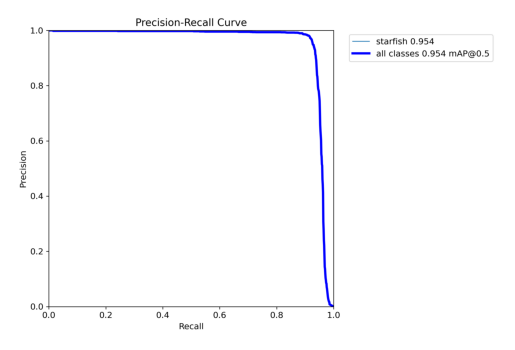

In [31]:
# plots results for yolov10l

rec_pre = Image.open(r"./runs/detect/train3/PR_curve.png")
fig, ax = plt.subplots()
ax.imshow(rec_pre)
ax.axis('off')
ax.spines['top'].set_visible(False)
ax.spines['right'].set_visible(False)
ax.spines['bottom'].set_visible(False)
ax.spines['left'].set_visible(False)
plt.show()

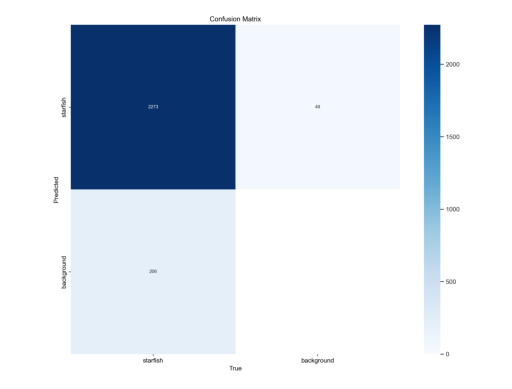

In [55]:
conf_mat = Image.open(r"./runs/detect/train3/confusion_matrix.png")
fig, ax = plt.subplots()
ax.imshow(conf_mat)
ax.axis('off')
ax.spines['top'].set_visible(False)
ax.spines['right'].set_visible(False)
ax.spines['bottom'].set_visible(False)
ax.spines['left'].set_visible(False)
plt.show()

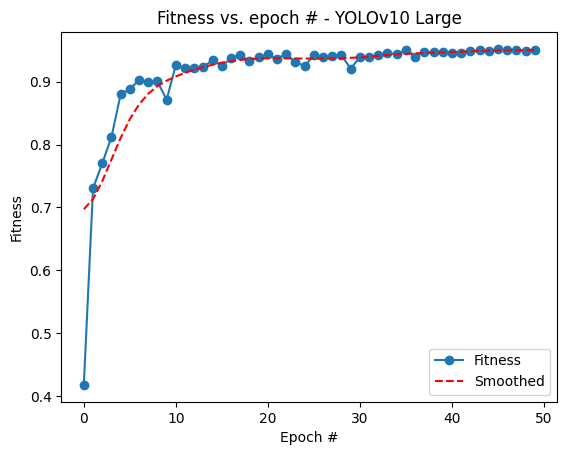

In [33]:
results_l = pd.read_csv(r"./runs/detect/train3/results.csv")
# results_n.axes[1] # show different key names
recall = results_l[results_n.axes[1][7]] 
map50 = results_l[results_n.axes[1][8]]
map5095 = results_l[results_n.axes[1][9]]
fitness_l = 0.2 * recall + 0.2 * map50 + 0.6 * map5095
fitness_smoothed_l = gaussian_filter1d(fitness, sigma=3) # Create a smoothed version of the training process
plt.plot(fitness_l, "-o", label="Fitness")
plt.plot(fitness_smoothed_l, "r--", label="Smoothed")
plt.title("Fitness vs. epoch # - YOLOv10 Large")
plt.xlabel("Epoch #")
plt.ylabel("Fitness")
plt.legend()

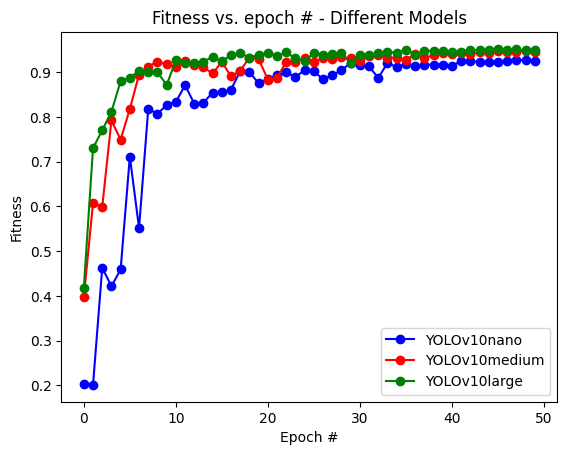

In [42]:
# Comparing the Different training processes and the different performances
fig, ax = plt.subplots()
ax.plot(fitness, "b-o", label="YOLOv10nano")
ax.plot(fitness_m, "r-o", label="YOLOv10medium")
ax.plot(fitness_l, "g-o", label="YOLOv10large")
plt.title("Fitness vs. epoch # - Different Models")
plt.xlabel("Epoch #")
plt.ylabel("Fitness")
plt.legend()

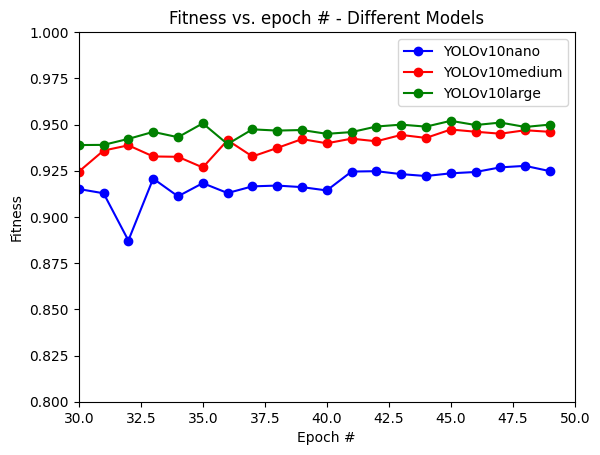

In [51]:
# Same as before but zooming on the high-performance areas

fig, ax = plt.subplots()
ax.plot(fitness, "b-o", label="YOLOv10nano")
ax.plot(fitness_m, "r-o", label="YOLOv10medium")
ax.plot(fitness_l, "g-o", label="YOLOv10large")
plt.ylim(0.8, 1)
plt.xlim(30, 50)
plt.title("Fitness vs. epoch # - Different Models")
plt.xlabel("Epoch #")
plt.ylabel("Fitness")
plt.legend()

In [16]:
!pip install dill
import dill
dill.dump_session('yolo_sizes_env.db')

Looking in indexes: https://pypi.org/simple, https://pypi.ngc.nvidia.com


TypeError: cannot pickle 'torch._C.Generator' object

In [58]:
import dill
dill.load_session("yolo_sizes_env.db")

EOFError: Ran out of input